# Import libraries and modules

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

In [3]:
import sys, os
# add project root (parent folder of the notebook) to sys.path
sys.path.append(os.path.abspath(".."))

from causalDA.data_generation import DataGenerator
from causalDA.plotting import plot_graph, plot_links_graph_svg
from reproduce.utils.config import BASE_RANGE, EDGE_PROB, INFLUENCE_FROM_PARENTS, NODE_LOOKUP, TARGET_NODE, TIME_PERIODS, sample_conversion_dict

from matplotlib import pyplot as plt
import pandas as pd

from dowhy import CausalModel as dowhyCausalModel
from dowhy import gcm
from causalDA.model import CausalModel

from reproduce.utils.helpers import snake_case, convert_effect_dict_to_links_dict, snake_case_dict

import re
import networkx as nx
import numpy as np
from collections import defaultdict
from sklearn.metrics import mean_squared_error

from IPython.display import SVG, display, HTML

# Gernerate synthetic data

## Configuration

# Generating Synthetic Causal Data

This guide walks you through generating synthetic time series data from a random DAG (Directed Acyclic Graph) using a custom `DataGenerator`
---

Information:

* We begin by creating an instance of `DataGenerator`, seeding the random number generator to ensure reproducibility.
* We simulate a random DAG based on a specified edge probability. Please refer to `utils/config` to change the parameters
* We create a dictionary `conversion_dict` that maps nodes to their conversion effectiveness.
* This `dag_result` will be a nested dictionary with relationships and weights that were used to generate the data — useful for interpretability or validation.

In [4]:
seed = 42
gen = DataGenerator(
    node_lookup=NODE_LOOKUP,
    target_node=TARGET_NODE,
    seed=seed,
)

graph = gen.generate_random_dag(edge_prob=EDGE_PROB)

conversion_dict = sample_conversion_dict()

df, dict_contributions, effect_dict = gen.generate_data(
    influence_from_parents=INFLUENCE_FROM_PARENTS,
    conversion_dict=conversion_dict,
    time_periods=TIME_PERIODS,
    base_range=BASE_RANGE,
    carryover=False,
)
df.columns = [snake_case(col) for col in df.columns]

dag_result = gen.get_causal_graph()

## Dataframe

In [5]:
all_channels = [snake_case(ch) for ch in NODE_LOOKUP.values() if ch != TARGET_NODE]
target_node = snake_case(TARGET_NODE)
data = df[[target_node] + all_channels]
data

,conversion,facebook,google_ads,tiktok,youtube,affiliates
0,1043.170700,1896.729898,1051.931173,1000.192571,2370.665746,1374.184000
1,940.562879,938.290260,1015.189257,1291.637186,2182.957111,1289.832010
2,1075.980111,1937.524194,1303.098555,1067.575636,2163.101509,1478.998059
3,1336.798461,1442.681273,1538.817606,2061.737885,2990.572272,1790.882386
4,1216.703847,1706.554077,1233.708053,1600.925900,2757.901054,1700.693249
...,...,...,...,...,...,...
360,1096.036383,1358.117015,1444.507184,1375.497888,2313.954651,1502.381140
361,1334.359879,1662.104919,1190.872925,1854.039790,2937.204556,2087.505202
362,1155.806261,1688.372027,1405.347105,1686.422064,2330.478990,1287.558731
363,1131.174032,1251.870708,1620.827135,1471.033270,2200.005833,1855.978135


## Causal Graph

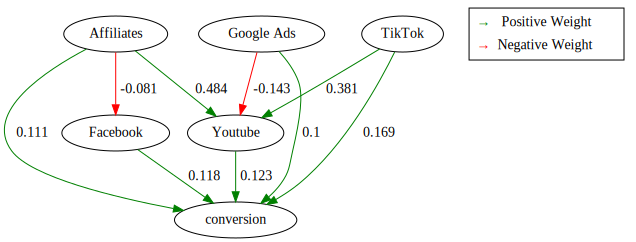

In [6]:
links_dict = convert_effect_dict_to_links_dict(effect_dict)
plot_links_graph_svg(links_dict, show_value=True)


## Visualisation

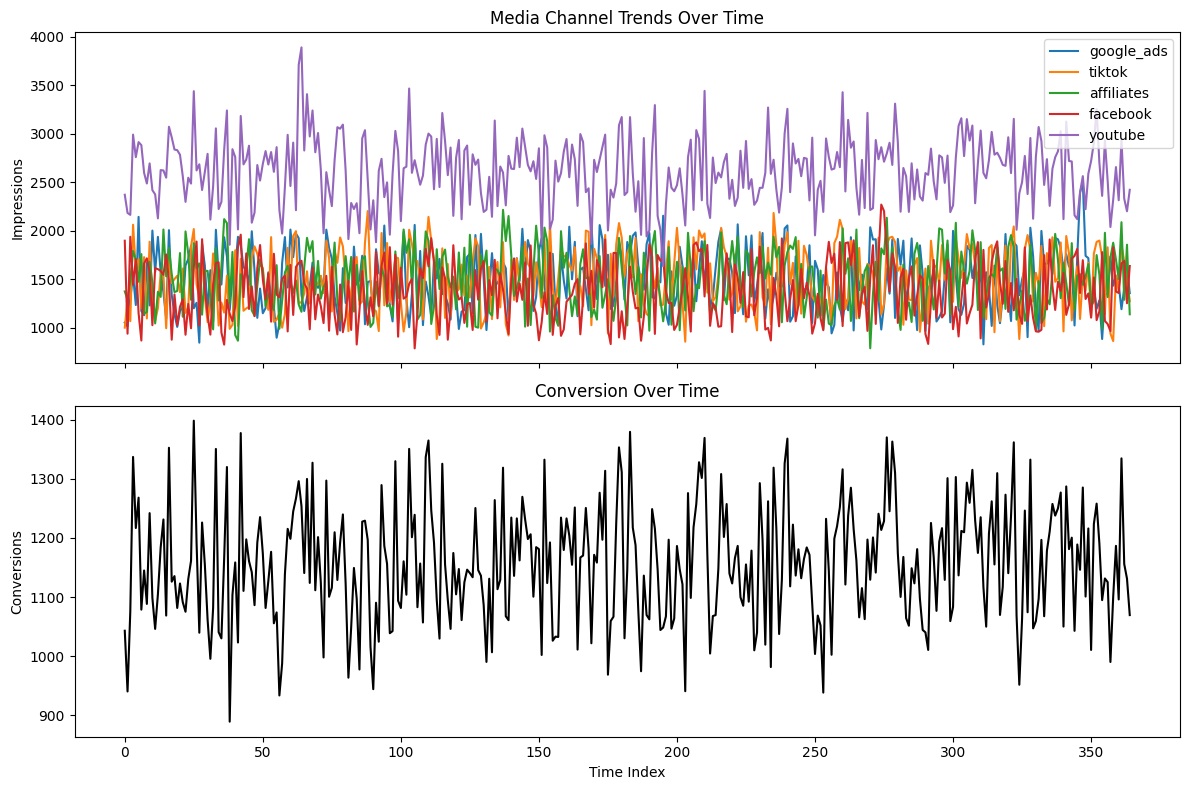

In [7]:
channels = df.columns[~df.columns.isin(['conversion', 'baseline'])].values
# Create two vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- Plot 1: Media Channels ---
for channel in channels:
    axes[0].plot(df.index, df[channel], label=channel)
axes[0].set_title('Media Channel Trends Over Time')
axes[0].set_ylabel('Impressions')
axes[0].legend()

# --- Plot 2: Conversion ---
axes[1].plot(df.index, df['conversion'], color='black')
axes[1].set_title('Conversion Over Time')
axes[1].set_xlabel('Time Index')
axes[1].set_ylabel('Conversions')

# Tidy up layout
plt.tight_layout()
plt.show()

# Causal-Driven Attribution

## Causal Discovery - PCMCI (Tigramite)

In [8]:
tau = 30

# Assume df is your synthetic dataset
selected_columns = all_channels + [target_node]

model = CausalModel(data, selected_columns, verbose=1)
results = model.run_pcmci(tau_max=tau, pc_alpha=0.2, alpha_level=0.05)

lagged_links = model.get_lagged_links(alpha_level=0.05, drop_source=target_node)
dag_links = model.prune_bidirectional_links(lagged_links)


pruned_dag = model.prune_cycles(dag_links, priority_node=target_node, verbose=True)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = robust_par_corr
tau_min = 1
tau_max = 30
pc_alpha = [0.2]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable facebook has 16 link(s):
        (youtube -30): max_pval = 0.01371, |min_val| =  0.141
        (affiliates -4): max_pval = 0.02818, |min_val| =  0.128
        (affiliates -25): max_pval = 0.03916, |min_val| =  0.120
        (affiliates -12): max_pval = 0.04477, |min_val| =  0.118
        (tiktok -15): max_pval = 0.04455, |min_val| =  0.115
        (google_ads -14): max_pval = 0.08769, |min_val| =  0.099
        (facebook -22): max_pval = 0.11094, |min_val| =  0.093
        (google_ads -23): max_pval = 0.14009, |min_val| =  0.085
        (tiktok -22): max_pval = 0.14646, |min_val| =  0.084
        (google_ads -9): max_pval = 0.15498, |min_val| =  0.083
        (facebook -1): max_pval = 0.14753, |min_val| =  0.083
        (google_ads -10)

### Visualisation

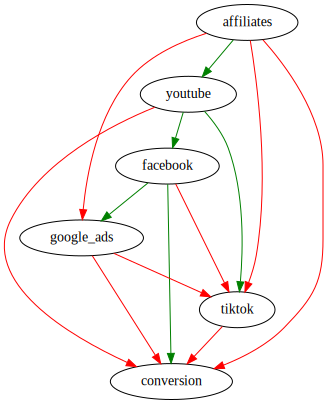

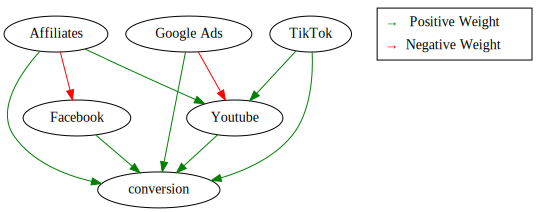

In [9]:
svg_prediction  = plot_links_graph_svg(pruned_dag, show_value=False, show_legend=False)
svg_groundtruth = plot_links_graph_svg(links_dict, show_value=False, show_legend=True)

# Wrap with titles and layout
html = f"""
<div style="display: flex; flex-direction: row; gap: 40px; align-items: flex-start; flex-wrap: nowrap;">
    <div style="text-align: center; width: 48%;">
        <h3>Predicted DAG</h3>
        {svg_prediction}
    </div>
    <div style="text-align: center; width: 48%;">
        <h3>Ground Truth DAG</h3>
        {svg_groundtruth}
    </div>
</div>
"""
display(HTML(html))


In [10]:
def build_causal_digraph(dag_result, extra_nodes=None, extra_edges=None):
    edges = []
    nodes = set()

    for effect, causes in dag_result.items():
        nodes.add(effect)
        for cause in causes:
            nodes.add(cause)
            edges.append(f'    {cause} -> {effect}')

    if extra_nodes:
        for node in extra_nodes:
            node = snake_case(node)
            nodes.add(node)

    if extra_edges:
        for src, dst in extra_edges:
            src = snake_case(src)
            dst = snake_case(dst)
            nodes.add(src)
            nodes.add(dst)
            edges.append(f'    {src} -> {dst}')

    # Build Graphviz digraph
    node_lines = [f'    {node}' for node in sorted(nodes)]
    graph = 'digraph {\n' + '\n'.join(node_lines + edges) + '\n}'
    return graph


In [11]:
model_causal_graph = build_causal_digraph(pruned_dag)
true_dag = snake_case_dict(links_dict)
true_causal_graph = build_causal_digraph(true_dag)

## Direct effect

### Using Ground Truth

In [17]:
true_ATE_result = {} # Average Treatment Effect


for source in all_channels:     
    model= dowhyCausalModel(
            data = data,
            graph=true_causal_graph,
            treatment=source,
            outcome=target_node)
    
    estimands = model.identify_effect()

    estimate= model.estimate_effect(
    identified_estimand=estimands,
    method_name='backdoor.linear_regression',
    confidence_intervals=True,
    test_significance=True
    )

    # Refute the obtained estimate using multiple robustness checks.
    refute_results = model.refute_estimate(estimands, estimate,
                                    method_name="random_common_cause")
    
    true_ATE_result[source] = {
        "ate": estimate.value
    }

true_ATE_result

{'facebook': {'ate': 0.12170943634464493},
 'google_ads': {'ate': 0.08165347531053158},
 'tiktok': {'ate': 0.21017190794009366},
 'youtube': {'ate': 0.123486954377654},
 'affiliates': {'ate': 0.13519395935634293}}

### Using Model

In [18]:
model_ATE_result = {} # Average Treatment Effect


for source in all_channels:     
        model= dowhyCausalModel(
                data = data,
                graph=model_causal_graph,
                treatment=source,
                outcome=target_node)
        
        estimands = model.identify_effect()

        estimate= model.estimate_effect(
        identified_estimand=estimands,
        method_name='backdoor.linear_regression',
        confidence_intervals=True,
        test_significance=True
        )

        # Refute the obtained estimate using multiple robustness checks.
        refute_results = model.refute_estimate(estimands, estimate,
                                        method_name="random_common_cause")
        
        model_ATE_result[source] = {
            "ate": estimate.value
        }

model_ATE_result

{'facebook': {'ate': 0.11668811957417802},
 'google_ads': {'ate': 0.07706584207880951},
 'tiktok': {'ate': 0.16904446833598286},
 'youtube': {'ate': 0.16594892215243817},
 'affiliates': {'ate': 0.13852831847543712}}

### Example - Grouth Truth

In [19]:
model= dowhyCausalModel(
        data = data,
        graph=true_causal_graph,
        treatment="tiktok",
        outcome="conversion")

estimands = model.identify_effect()
print(estimands)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                   
─────────(E[conversion])
d[tiktok]               
Estimand assumption 1, Unconfoundedness: If U→{tiktok} and U→conversion then P(conversion|tiktok,,U) = P(conversion|tiktok,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
    d                   
─────────(E[conversion])
d[tiktok]               
Estimand assumption 1, Unconfoundedness: If U→{tiktok} and U→conversion then P(conversion|tiktok,,U) = P(conversion|tiktok,)



In [20]:
estimate= model.estimate_effect(
  identified_estimand=estimands,
  method_name='backdoor.linear_regression',
  confidence_intervals=True,
  test_significance=True
)

# Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(estimands, estimate,
                                       method_name="random_common_cause")

print(f'Estimate of causal effect: {estimate}')
print(f'Refute results: {refute_results}')

Estimate of causal effect: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                   
─────────(E[conversion])
d[tiktok]               
Estimand assumption 1, Unconfoundedness: If U→{tiktok} and U→conversion then P(conversion|tiktok,,U) = P(conversion|tiktok,)

## Realized estimand
b: conversion~tiktok+tiktok*google_ads+tiktok*affiliates+tiktok*facebook
Target units: 

## Estimate
Mean value: 0.21017190794009366
p-value: [1.10420155e-16]
95.0% confidence interval: (0.19767720503807595, 0.22263635569629514)
### Conditional Estimates
__categorical__google_ads      __categorical__affiliates  __categorical__facebook
(828.0640000000001, 1193.045]  (787.979, 1187.592]        (786.818, 1066.964]        0.119435
                                                          (1066.964, 1256.433]       0.133305
                                                          (1256.433, 

### Example - Model

In [ ]:
model= dowhyCausalModel(
        data = data,
        graph=model_causal_graph,
        treatment="tiktok",
        outcome="conversion")

estimands = model.identify_effect()
print(estimands)

In [ ]:
estimate= model.estimate_effect(
  identified_estimand=estimands,
  method_name='backdoor.linear_regression',
  confidence_intervals=True,
  test_significance=True
)

# Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(estimands, estimate,
                                       method_name="random_common_cause")

print(f'Estimate of causal effect: {estimate}')
print(f'Refute results: {refute_results}')

## Incremental causal attribution

In [26]:
def estimate_conversion_drop_via_sampling_repeated(
    scm,
    data: pd.DataFrame,
    channel: str,
    target: str = "conversion",
    n_runs: int = 5000
) -> float:
    drops = []
    for _ in range(n_runs):
        baseline = gcm.interventional_samples(scm, {}, observed_data=data)
        after_do = gcm.interventional_samples(scm, {channel: lambda x: 0.0}, observed_data=data)
        drop = baseline[target].mean() - after_do[target].mean()
        drops.append(drop)
    return float(np.mean(drops))

In [27]:
def calculate_causal_effect_per_unit(conversion_drop: float, channel_series: pd.Series) -> float:
    mean_input = channel_series.mean()
    if mean_input == 0:
        raise ValueError("Mean of channel is zero; can't divide by zero.")
    return conversion_drop / mean_input

### Using Ground Truth

In [36]:
# Extract edges using regex
edges = re.findall(r'(\w+)\s*->\s*(\w+)', true_causal_graph)

# Create the DiGraph
converted_causal_graph = nx.DiGraph(edges)

In [37]:
# Create the structural causal model object
scm_true = gcm.StructuralCausalModel(converted_causal_graph)

In [38]:
# Automatically assign generative models to each node based on the given data
gcm.auto.assign_causal_mechanisms(scm_true, data)

In [39]:
gcm.fit(scm_true, data)

Fitting causal mechanism of node conversion: 100%|██████████| 6/6 [00:00<00:00, 390.26it/s]


In [40]:
true_ACE_result = {} # Average Causal Effect

for source in all_channels:
    channel_drop = estimate_conversion_drop_via_sampling_repeated(scm_true, data, source, target = target_node, n_runs = 5000)
    channel_mean = data[source].mean()
    causal_effect = calculate_causal_effect_per_unit(channel_drop, data[source])
    true_ACE_result[source] = {
        "conversion_drop": channel_drop,
        "ace": causal_effect
    }
true_ACE_result

{'facebook': {'conversion_drop': 162.38757215874128,
  'ace': 0.11789047212430562},
 'google_ads': {'conversion_drop': 121.91129729796766,
  'ace': 0.08141937511045959},
 'tiktok': {'conversion_drop': 324.3813205285199, 'ace': 0.2151277525445591},
 'youtube': {'conversion_drop': 324.6285215742166, 'ace': 0.12405604510156824},
 'affiliates': {'conversion_drop': 209.59205004743873,
  'ace': 0.1402677525970558}}

### Example - Ground Truth

In [1]:
source = "facebook"
channel_drop = estimate_conversion_drop_via_sampling_repeated(scm_true, data, source, target = target_node, n_runs = 5000)
print(f"Estimated drop on {target_node} if {source} is turned off: {channel_drop:.2f}")

channel_mean = data[source].mean()

causal_effect = calculate_causal_effect_per_unit(channel_drop, data[source])
print(f"Causal effect of {source} per unit: {causal_effect:.4f} conversions per unit increase")


NameError: name 'estimate_conversion_drop_via_sampling_repeated' is not defined

### Using Model

In [29]:
# Extract edges using regex
edges = re.findall(r'(\w+)\s*->\s*(\w+)', model_causal_graph)

# Create the DiGraph
converted_causal_graph = nx.DiGraph(edges)

In [30]:
# Create the structural causal model object
scm_model = gcm.StructuralCausalModel(converted_causal_graph)

In [31]:
# Automatically assign generative models to each node based on the given data
gcm.auto.assign_causal_mechanisms(scm_model, data)

In [32]:
gcm.fit(scm_model, data)

Fitting causal mechanism of node conversion: 100%|██████████| 6/6 [00:00<00:00, 187.11it/s]


In [35]:
model_ACE_result = {} # Average Causal Effect

for source in all_channels:
    channel_drop = estimate_conversion_drop_via_sampling_repeated(scm_model, data, source, target = target_node, n_runs = 5000)
    channel_mean = data[source].mean()
    causal_effect = calculate_causal_effect_per_unit(channel_drop, data[source])
    model_ACE_result[source] = {
        "conversion_drop": channel_drop,
        "ace": causal_effect
    }
model_ACE_result

{'facebook': {'conversion_drop': 178.4505439977297,
  'ace': 0.12955190229807914},
 'google_ads': {'conversion_drop': 157.71338678957784,
  'ace': 0.1053300693501496},
 'tiktok': {'conversion_drop': 254.8888513695321, 'ace': 0.16904076244109925},
 'youtube': {'conversion_drop': 458.37774710792183,
  'ace': 0.17516800493383394},
 'affiliates': {'conversion_drop': 232.59074939632956,
  'ace': 0.15565944264252327}}

In [34]:
source = "facebook"
channel_drop = estimate_conversion_drop_via_sampling_repeated(scm_model, data, source, target = target_node, n_runs = 5000)
print(f"Estimated drop on {target_node} if {source} is turned off: {channel_drop:.2f}")

channel_mean = data[source].mean()

causal_effect = calculate_causal_effect_per_unit(channel_drop, data[source])
print(f"Causal effect of {source} per unit: {causal_effect:.4f} conversions per unit increase")


Estimated drop on conversion if facebook is turned off: 178.39
Causal effect of facebook per unit: 0.1295 conversions per unit increase


# Evaluation

## Ground Truth

In [58]:
def compute_causal_effects(links_dict, outcome='conversion'):
    """
    Computes direct and total causal effects from a DAG links_dict to a specified outcome variable.

    Args:
        links_dict (dict): DAG in the format {target: {source: {'value': weight, 'lag': int}}}
        outcome (str): Name of the outcome node (default: 'conversion')

    Returns:
        dict: direct_effects
        dict: total_effects
    """

    # Direct effects: only edges pointing to the outcome node
    direct_effect = {
        src: data['value']
        for src, data in links_dict.get(outcome, {}).items()
    }

    # Build adjacency list: source -> list of (target, weight)
    edges = defaultdict(list)
    for target, parents in links_dict.items():
        for parent, data in parents.items():
            edges[parent].append((target, data['value']))

    # Recursive function to find all weighted paths from node to outcome
    def get_paths_to_outcome(node, visited=None, cumulative=1.0):
        if visited is None:
            visited = set()
        if node in visited:
            return []
        visited.add(node)
        paths = []
        for child, weight in edges[node]:
            new_cumulative = cumulative * weight
            if child == outcome:
                paths.append(new_cumulative)
            else:
                paths += get_paths_to_outcome(child, visited.copy(), new_cumulative)
        return paths

    # Total effects: sum of all path weights to the outcome
    total_effect = {}
    for node in edges.keys():
        paths = get_paths_to_outcome(node)
        if paths:
            total_effect[node] = sum(paths)

    return direct_effect, total_effect


In [59]:
direct_effect, total_effect = compute_causal_effects(links_dict)
print("Direct:", direct_effect)
print("Total:", total_effect)

Direct: {'Facebook': 0.1181565812704725, 'Google Ads': 0.10003893829205072, 'TikTok': 0.16922115592912176, 'Youtube': 0.12322370567394016, 'Affiliates': 0.1111653160488281}
Total: {'Affiliates': 0.16119500549925309, 'Google Ads': 0.08238431167618257, 'TikTok': 0.2161454831837214, 'Facebook': 0.1181565812704725, 'Youtube': 0.12322370567394016}


## Direct effect

### Ground Truth - Estimation

In [46]:
# Compute RMSE
# Normalize direct_effect keys
normalized_direct = {snake_case(k): v for k, v in direct_effect.items()}

# Align keys
common_keys = list(set(normalized_direct.keys()) & set(true_ATE_result.keys()))
direct_vals = [normalized_direct[k] for k in common_keys]
true_ate_vals = [true_ATE_result[k]['ate'] for k in common_keys]

# Compute RMSE
true_rmse = np.sqrt(mean_squared_error(true_ate_vals, direct_vals))
print(f"RMSE between Direct Effect and ATE: {true_rmse:.5f}")

true_relative_rmse = true_rmse / np.mean(true_ate_vals)
print(f"Relative RMSE: {true_relative_rmse:.2%}")

RMSE between Direct Effect and ATE: 0.02283
Relative RMSE: 16.98%


### Model -Estimation

In [47]:
# Compute RMSE
# Normalize direct_effect keys
normalized_direct = {snake_case(k): v for k, v in direct_effect.items()}

# Align keys
common_keys = list(set(normalized_direct.keys()) & set(model_ATE_result.keys()))
direct_vals = [normalized_direct[k] for k in common_keys]
model_ate_vals = [model_ATE_result[k]['ate'] for k in common_keys]

# Compute RMSE
model_rmse = np.sqrt(mean_squared_error(model_ate_vals, direct_vals))
print(f"RMSE between Direct Effect and ATE: {model_rmse:.5f}")

model_relative_rmse = model_rmse / np.mean(model_ate_vals)
print(f"Relative RMSE: {model_relative_rmse:.2%}")

RMSE between Direct Effect and ATE: 0.02492
Relative RMSE: 18.67%


### Visualisation

#### Grouth Truth

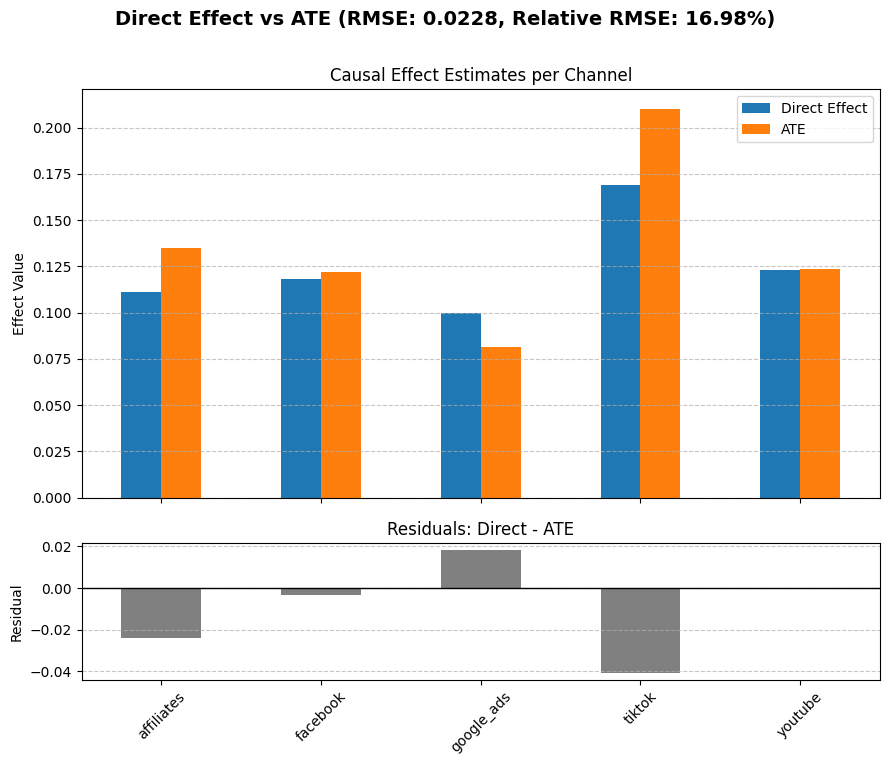

In [48]:
# Create DataFrame
normalized_ate = {k: v['ate'] for k, v in true_ATE_result.items()}
# Create DataFrame
df = pd.DataFrame({
    'Direct Effect': pd.Series(normalized_direct),
    'ATE': pd.Series(normalized_ate)
})
df['Residual (Direct - ATE)'] = df['Direct Effect'] - df['ATE']
df = df.sort_index()

# Compute RMSE
ate_vals = df['ATE'].values
direct_vals = df['Direct Effect'].values
rmse = np.sqrt(mean_squared_error(ate_vals, direct_vals))
relative_rmse = rmse / np.mean(ate_vals)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Title with RMSE
fig.suptitle(
    f"Direct Effect vs ATE (RMSE: {rmse:.4f}, Relative RMSE: {relative_rmse:.2%})",
    fontsize=14,
    fontweight='bold',
    y=0.95
)

# Top bar plot
df[['Direct Effect', 'ATE']].plot(kind='bar', ax=ax[0])
ax[0].set_ylabel('Effect Value')
ax[0].set_title('Causal Effect Estimates per Channel', fontsize=12)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

# Residuals bar plot
df['Residual (Direct - ATE)'].plot(kind='bar', ax=ax[1], color='gray')
ax[1].axhline(0, color='black', linewidth=1)
ax[1].set_ylabel('Residual')
ax[1].set_title('Residuals: Direct - ATE', fontsize=12)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.94])  # leave space for suptitle
plt.show()

#### Model

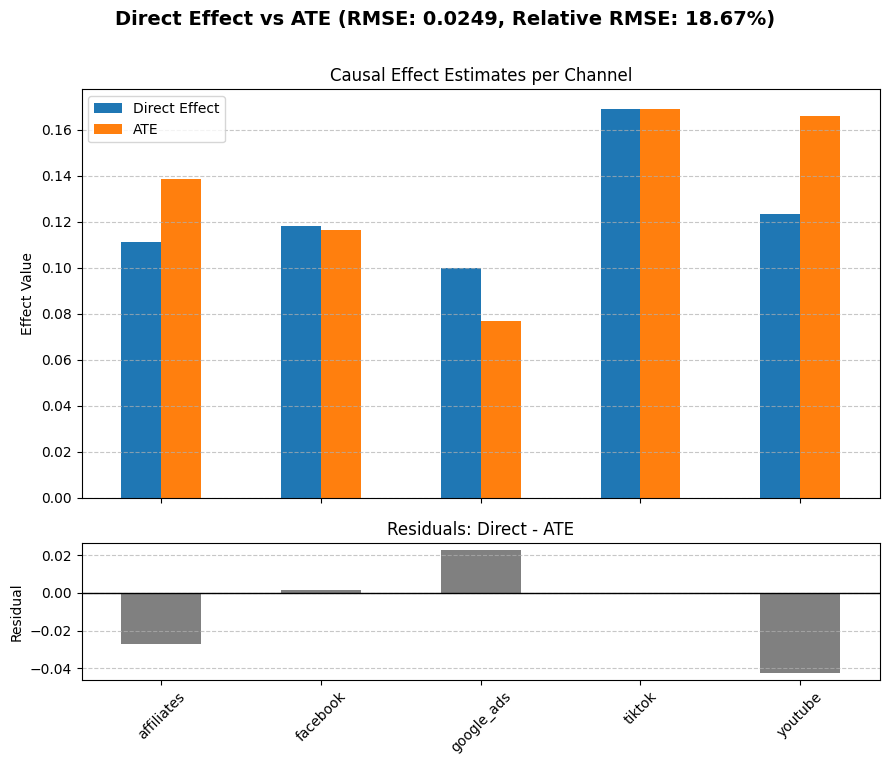

In [49]:
# Create DataFrame
normalized_ate = {k: v['ate'] for k, v in model_ATE_result.items()}
# Create DataFrame
df = pd.DataFrame({
    'Direct Effect': pd.Series(normalized_direct),
    'ATE': pd.Series(normalized_ate)
})
df['Residual (Direct - ATE)'] = df['Direct Effect'] - df['ATE']
df = df.sort_index()

# Compute RMSE
ate_vals = df['ATE'].values
direct_vals = df['Direct Effect'].values
rmse = np.sqrt(mean_squared_error(ate_vals, direct_vals))
relative_rmse = rmse / np.mean(ate_vals)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Title with RMSE
fig.suptitle(
    f"Direct Effect vs ATE (RMSE: {rmse:.4f}, Relative RMSE: {relative_rmse:.2%})",
    fontsize=14,
    fontweight='bold',
    y=0.95
)

# Top bar plot
df[['Direct Effect', 'ATE']].plot(kind='bar', ax=ax[0])
ax[0].set_ylabel('Effect Value')
ax[0].set_title('Causal Effect Estimates per Channel', fontsize=12)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

# Residuals bar plot
df['Residual (Direct - ATE)'].plot(kind='bar', ax=ax[1], color='gray')
ax[1].axhline(0, color='black', linewidth=1)
ax[1].set_ylabel('Residual')
ax[1].set_title('Residuals: Direct - ATE', fontsize=12)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.94])  # leave space for suptitle
plt.show()

## Causal Effect (Total Effect)

### Estimation

#### Ground Truth

In [50]:
# Compute RMSE
# Normalize direct_effect keys
normalized_total = {snake_case(k): v for k, v in total_effect.items()}

# Align keys
common_keys = list(set(normalized_total.keys()) & set(true_ACE_result.keys()))
total_vals = [normalized_total[k] for k in common_keys]
ace_vals = [true_ACE_result[k]['ace'] for k in common_keys]

# Compute RMSE
rmse = np.sqrt(mean_squared_error(ace_vals, total_vals))
print(f"RMSE between Total Effect and ACE: {rmse:.5f}")

relative_rmse = rmse / np.mean(ace_vals)
print(f"Relative RMSE: {relative_rmse:.2%}")

RMSE between Total Effect and ACE: 0.00939
Relative RMSE: 6.92%


#### Model

In [52]:
# Compute RMSE
# Normalize direct_effect keys
normalized_total = {snake_case(k): v for k, v in total_effect.items()}

# Align keys
common_keys = list(set(normalized_total.keys()) & set(model_ACE_result.keys()))
total_vals = [normalized_total[k] for k in common_keys]
ace_vals = [model_ACE_result[k]['ace'] for k in common_keys]

# Compute RMSE
rmse = np.sqrt(mean_squared_error(ace_vals, total_vals))
print(f"RMSE between Total Effect and ACE: {rmse:.5f}")

relative_rmse = rmse / np.mean(ace_vals)
print(f"Relative RMSE: {relative_rmse:.2%}")

RMSE between Total Effect and ACE: 0.03348
Relative RMSE: 22.78%


### Visualisation

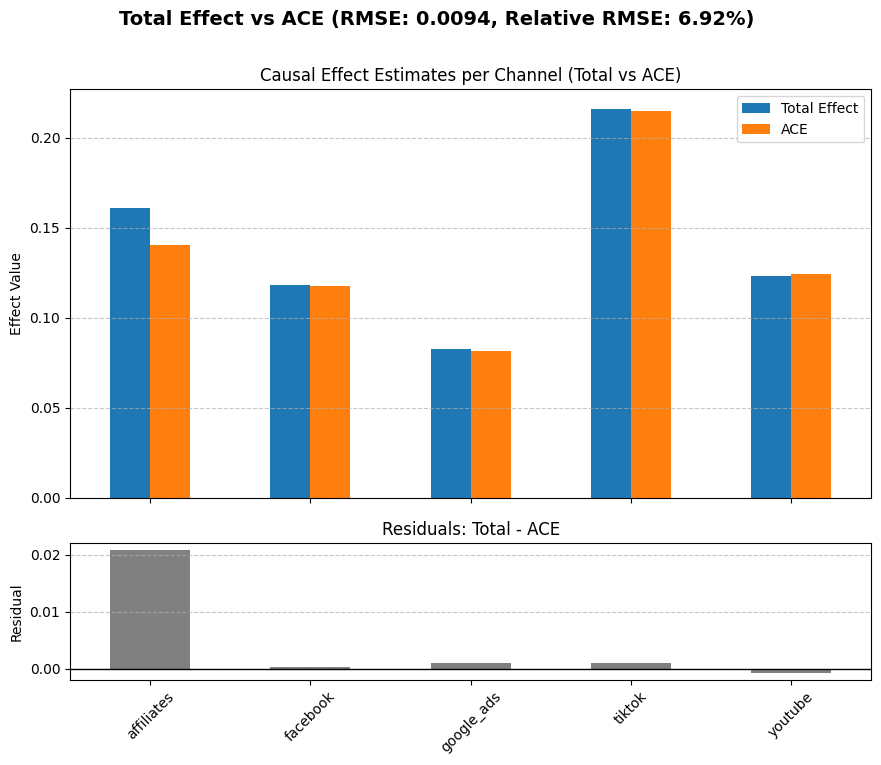

In [53]:
# Prepare DataFrame
normalized_ace = {k: v['ace'] for k, v in true_ACE_result.items()}
df = pd.DataFrame({
    'Total Effect': pd.Series(normalized_total),
    'ACE': pd.Series(normalized_ace)
})
df['Residual (Total - ACE)'] = df['Total Effect'] - df['ACE']
df = df.sort_index()

# Compute RMSE
ace_vals = df['ACE'].values
total_vals = df['Total Effect'].values
rmse = np.sqrt(mean_squared_error(ace_vals, total_vals))
relative_rmse = rmse / np.mean(ace_vals)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Title with RMSE
fig.suptitle(
    f"Total Effect vs ACE (RMSE: {rmse:.4f}, Relative RMSE: {relative_rmse:.2%})",
    fontsize=14,
    fontweight='bold',
    y=0.95
)

# Top bar plot
df[['Total Effect', 'ACE']].plot(kind='bar', ax=ax[0])
ax[0].set_ylabel('Effect Value')
ax[0].set_title('Causal Effect Estimates per Channel (Total vs ACE)', fontsize=12)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

# Residuals bar plot
df['Residual (Total - ACE)'].plot(kind='bar', ax=ax[1], color='gray')
ax[1].axhline(0, color='black', linewidth=1)
ax[1].set_ylabel('Residual')
ax[1].set_title('Residuals: Total - ACE', fontsize=12)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.94])  # leave space for suptitle
plt.show()

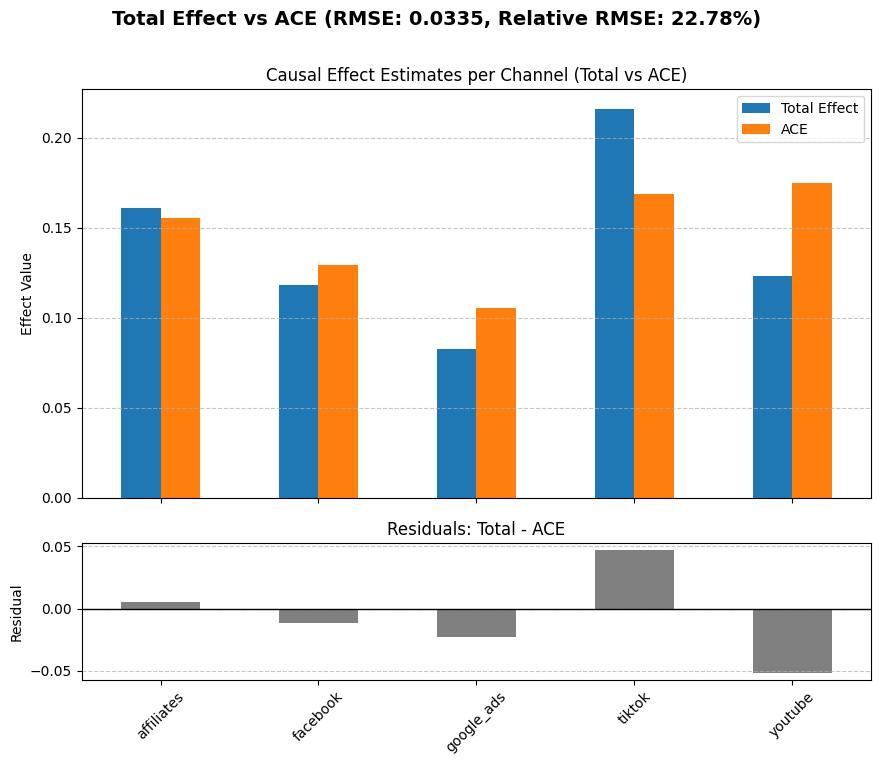

In [54]:
# Prepare DataFrame
normalized_ace = {k: v['ace'] for k, v in model_ACE_result.items()}
df = pd.DataFrame({
    'Total Effect': pd.Series(normalized_total),
    'ACE': pd.Series(normalized_ace)
})
df['Residual (Total - ACE)'] = df['Total Effect'] - df['ACE']
df = df.sort_index()

# Compute RMSE
ace_vals = df['ACE'].values
total_vals = df['Total Effect'].values
rmse = np.sqrt(mean_squared_error(ace_vals, total_vals))
relative_rmse = rmse / np.mean(ace_vals)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Title with RMSE
fig.suptitle(
    f"Total Effect vs ACE (RMSE: {rmse:.4f}, Relative RMSE: {relative_rmse:.2%})",
    fontsize=14,
    fontweight='bold',
    y=0.95
)

# Top bar plot
df[['Total Effect', 'ACE']].plot(kind='bar', ax=ax[0])
ax[0].set_ylabel('Effect Value')
ax[0].set_title('Causal Effect Estimates per Channel (Total vs ACE)', fontsize=12)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

# Residuals bar plot
df['Residual (Total - ACE)'].plot(kind='bar', ax=ax[1], color='gray')
ax[1].axhline(0, color='black', linewidth=1)
ax[1].set_ylabel('Residual')
ax[1].set_title('Residuals: Total - ACE', fontsize=12)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.94])  # leave space for suptitle
plt.show()

In [ ]:
# Evaluation the ca